In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scipy.optimize import linear_sum_assignment

np.random.seed(0)
torch.manual_seed(0)
from torch.nn.utils import weight_norm
device = torch.device('cuda:0')

In [2]:
key = {'Orange':0,'Green':1,'Black':2,'Purple':3,'White':4,'LBlue':5,'Blue':6}

In [3]:
extraction_orders = np.genfromtxt('./extraction_order.txt',delimiter=',',dtype=str)

In [4]:
images = np.load('cube_ims.npy')
print (images.shape)

(240, 4, 64, 64, 3)


In [5]:
actions = np.vectorize(key.get)(extraction_orders)
print(actions.shape)

(240, 7)


In [6]:
K = 7
a_one_hot = np.zeros((actions.shape[0],K,K))
for i,a in enumerate(actions):
    oh = np.zeros((K,K))
    oh[np.arange(a.shape[0]),a] = 1
    a_one_hot[i,:,:] = oh

In [7]:
class Sampler(Dataset):
    
    def __init__(self, ims, actions, K=6):
        
        self.ims = torch.FloatTensor(ims.astype('float'))
        self.actions = torch.FloatTensor(actions.astype('float')).long()
        self.indices = torch.FloatTensor(np.arange(ims.shape[0]))
        self.K = K
        
        
    def __len__(self):
        
        return self.ims.shape[0]
    
    def __getitem__(self, index):
        
        im = self.ims[index,:,:,:].reshape(-1,64,64)
        actions = self.actions[index,:]
        return im.to(device), actions.to(device), torch.eye(self.K).to(device),self.indices[index].to(device)


In [8]:
dataset = Sampler(np.swapaxes(np.stack(images),2,4),actions,7)

train_dataset,test_dataset = torch.utils.data.random_split(dataset, [180,60])

In [9]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class TCNNet(nn.Module):

    def __init__(self, latent_dim=16, image_channels=3, K=6):
        super(TCNNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            Flatten(),
            nn.Linear(4096, latent_dim*K),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        
        self.tcn = TemporalConvNet(K,[K]*K)
        
        # Sinkhorn params
        self.latent_dim = latent_dim
        self.K = K
        
        self.criterion = nn.CrossEntropyLoss()

        self.fc = nn.Sequential(
                         nn.Linear(latent_dim, K))
    
    def forward(self, im):
        
        latent = self.encoder(im)
        stacked_latent = torch.reshape(latent,(-1,self.K,self.latent_dim))
        
        tc = self.tcn(stacked_latent)
        
        y = self.fc(tc)
        logits = torch.nn.functional.softmax(y,dim=-1)
        return logits
    
    def loss(self, seq, im):
        
        seq_logits = self.forward(im)

        return self.criterion(seq_logits.view(-1,self.K),seq.view(-1)), seq_logits

In [11]:
bc = TCNNet(latent_dim=128, image_channels=12, K=7)
bc.to(device)
optimizer = torch.optim.Adam(bc.parameters(), lr=3e-4)
n_epochs = 1500
losses = []

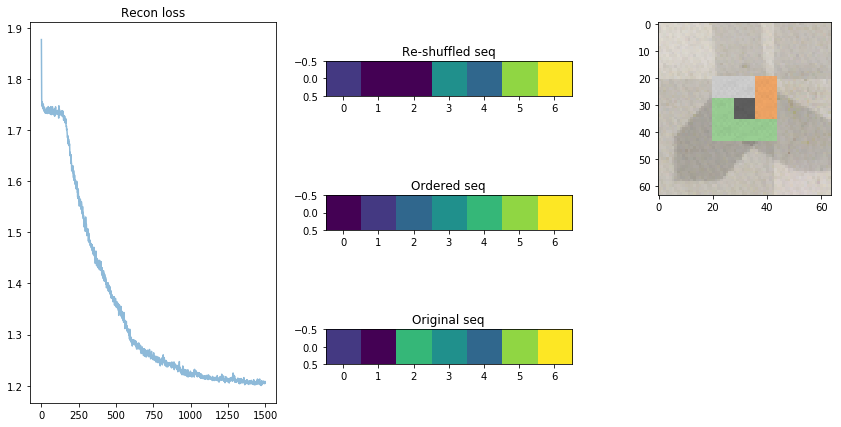

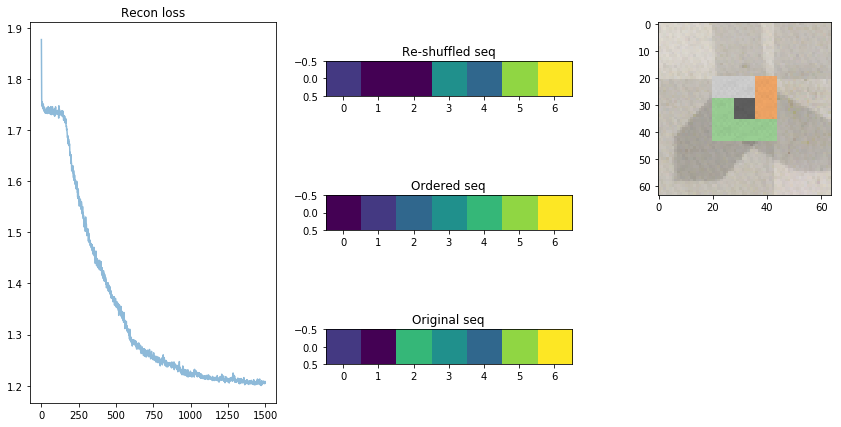

In [12]:
plt.figure(figsize=(15,7))

for j in range(n_epochs):
    
    batch_losses = []
    for im, seq, seq_order,_ in train_loader:
    
        loss, seq_pred = bc.loss(seq, im)
        
        batch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    losses.append(np.mean(batch_losses))
    
    plt.clf()
    plt.cla()
    plt.subplot(1,3,1)
    plt.plot(losses,alpha=0.5)
    plt.title('Recon loss')
    
    plt.subplot(3,3,2)
    plt.imshow(np.argmax(seq_pred[0,:].cpu().detach().numpy(),-1).reshape(1,-1))
    plt.title('Re-shuffled seq')
    
    plt.subplot(3,3,5)
    plt.imshow(np.argmax(seq_order[0,:].cpu().detach().numpy(),-1).reshape(1,-1))
    plt.title('Ordered seq')
    
    plt.subplot(3,3,8)
    plt.imshow(seq[0,:].cpu().detach().numpy().reshape(1,-1))
    plt.title('Original seq')
    
    plt.subplot(2,3,3)
    plt.imshow(np.swapaxes(im[0,0:3,:,:].cpu().detach().numpy(),0,2))
    
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [13]:
bc.eval()

TCNNet(
  (encoder): Sequential(
    (0): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten()
    (12): Linear(in_features=4096, out_features=896, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
  )
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(7, 7, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (c

In [14]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

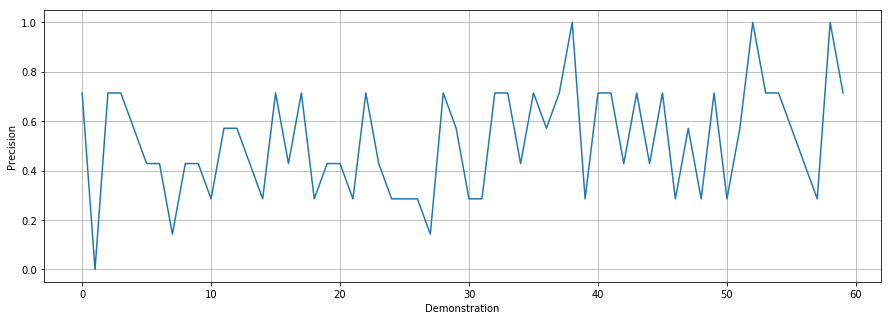

In [15]:
prec_list = []
actions_pred = []
index_list = []
for im,seq,seq_ordered,indices in test_loader:
    logits = bc(im)
    
    index_list.append(indices.cpu().numpy())
    _,obj_ids = linear_sum_assignment(1-logits[0,:,:].cpu().detach().numpy())
    actions_pred.append(obj_ids)
    prec = np.sum(obj_ids==seq.cpu().numpy())/7
    prec_list.append(prec)

plt.figure(figsize=(15,5))
plt.plot(prec_list)
plt.ylabel('Precision')
plt.xlabel('Demonstration')
plt.grid()
plt.show()

In [16]:
np.mean(prec_list)

0.5166666666666666

In [17]:
parts = [k[0] for k in key.items()]

In [18]:
pred_extractions = np.array(parts)[np.array(actions_pred).astype(int)]
indices = np.array(index_list).astype(int)

In [19]:
np.save('pred_order_tcn.npy',pred_extractions)
np.save('test_indices_tcn.npy',indices)